# 银行客户营销响应预测模型 (Bank Marketing Response Prediction)

## 1. 项目背景与商业目标

本项目旨在通过分析银行现有客户的人口统计信息、历史交易行为以及过往营销接触记录，构建一个机器学习模型，以精准预测客户**是否会响应电话营销并购买定期存款产品**。

在金融行业，精准营销是驱动业务增长的核心。相比于盲目地对所有客户进行电话营销，一个有效的预测模型可以帮助银行：
*   **提升营销效率 (Increase Efficiency)**: 将有限的人力与营销资源，集中在最有可能转化的“高潜力”客户身上。
*   **降低客户打扰 (Reduce Disturbance)**: 避免对无意向的客户进行过度营销，提升客户满意度。
*   **最大化营销回报率 (Maximize ROI)**: 用更低的成本，获得更多的存款业务。

**核心目标:**
1.  对客户画像及营销相关特征进行深度EDA，发掘影响客户决策的关键因素。
2.  应用分类模型（如逻辑回归、LightGBM）预测客户的响应概率。
3.  通过模型解读，为银行的营销策略制定提供数据驱动的建议。

## 2. 数据加载与特征解读

本节我们将加载数据集，并对每个特征的业务含义进行解读。理解这些特征是后续分析和建模的基础。

Dataset shape: (11162, 17)

First 5 rows:
   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIn

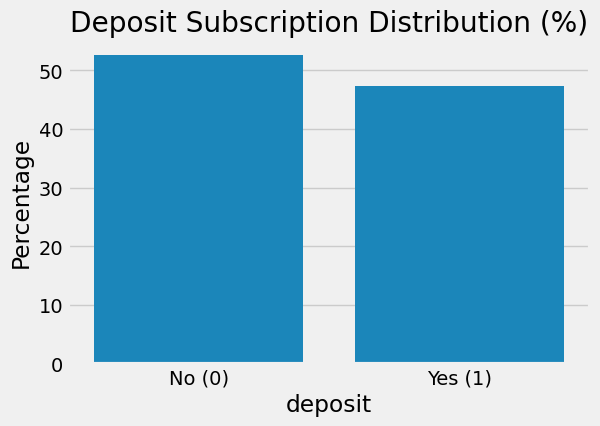

In [12]:
# -----------------------------------
# 1. 导入基础库
# -----------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# -----------------------------------
# 2. 设置与数据加载
# -----------------------------------
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# 加载数据
df = pd.read_csv('bank.csv')

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# 查看数据基本信息，特别是数据类型和缺失值
print("\nData Info:")
df.info()

# -----------------------------------
# 3. 特征业务含义解读
# -----------------------------------
# 人口统计学特征 (Demographic):
# age: 年龄
# job: 职业 (e.g., 'admin.', 'blue-collar', 'technician')
# marital: 婚姻状况 ('married', 'single', 'divorced')
# education: 教育程度 ('secondary', 'tertiary', 'primary')

# 客户与银行关系特征 (Client-Bank Relationship):
# default: 是否有信用违约记录 ('yes', 'no')
# balance: 年度平均余额 (单位：欧元)
# housing: 是否有住房贷款 ('yes', 'no')
# loan: 是否有个人贷款 ('yes', 'no')

# 本次营销活动相关特征 (Current Campaign):
# contact: 联系方式 ('cellular', 'telephone', 'unknown')
# day: 本月最后一次联系的日期 (1-31)
# month: 本月最后一次联系的月份 ('jan', 'feb', ..., 'dec')
# duration: 本次通话时长（秒）。

# 历史营销活动相关特征 (Past Campaigns):
# campaign: 在本次营销活动中，联系该客户的总次数
# pdays: 距离上一次联系该客户的天数 (-1 表示之前从未联系过)
# previous: 在本次营销活动之前，联系该客户的总次数
# poutcome: 上一次营销活动的结果 ('success', 'failure', 'other', 'unknown')

# 目标变量 (Target Variable):
# deposit: 客户最终是否购买了定期存款产品 ('yes', 'no')


# -----------------------------------
# 4. 目标变量处理与探索
# -----------------------------------
# 将目标变量 'deposit' 从 'yes'/'no' 转换为 1/0
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})

# 查看目标变量分布
print("\nTarget variable 'deposit' distribution:")
deposit_dist = df['deposit'].value_counts(normalize=True) * 100
print(deposit_dist)

# 可视化目标变量分布
plt.figure(figsize=(6, 4))
sns.barplot(x=deposit_dist.index, y=deposit_dist.values)
plt.title('Deposit Subscription Distribution (%)')
plt.ylabel('Percentage')
plt.xticks([0, 1], ['No (0)', 'Yes (1)'])
plt.show()


# 3. 探索性数据分析 (EDA) - 寻找高潜力客群

在这一部分，我们将深入探索不同客户特征与他们是否购买产品(`deposit`)之间的关系。我们的目标是回答一些核心的业务问题：

*   **什么样的客户更愿意购买我们的产品？** (客户画像分析)
*   **在什么时间、以什么方式联系客户，成功率更高？** (营销渠道与时机分析)
*   **过去的营销活动对现在有何影响？** (历史行为分析)

通过回答这些问题，我们可以为营销团队提供清晰的用户画像和策略建议。

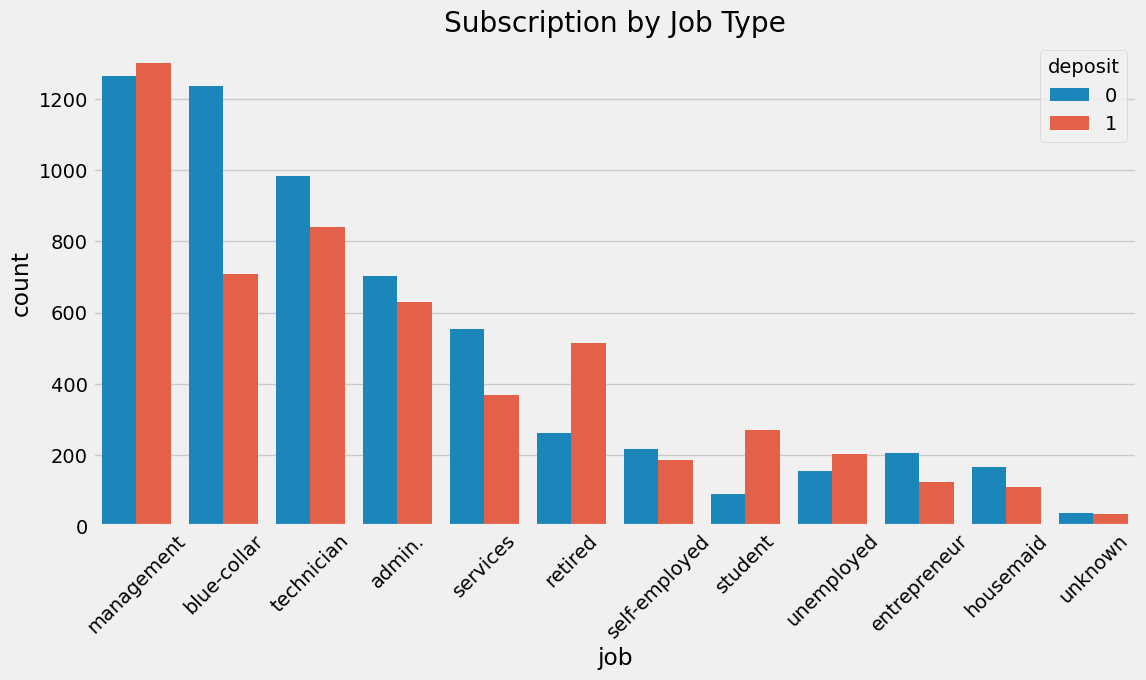

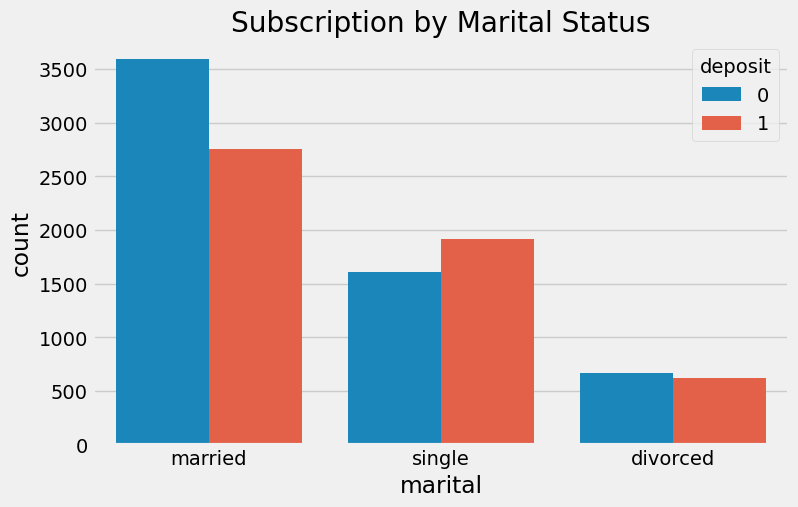

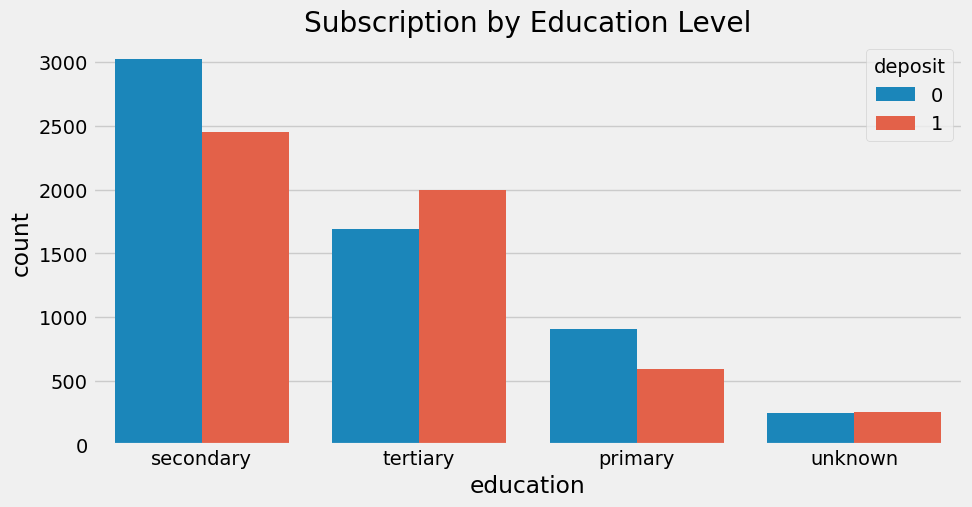

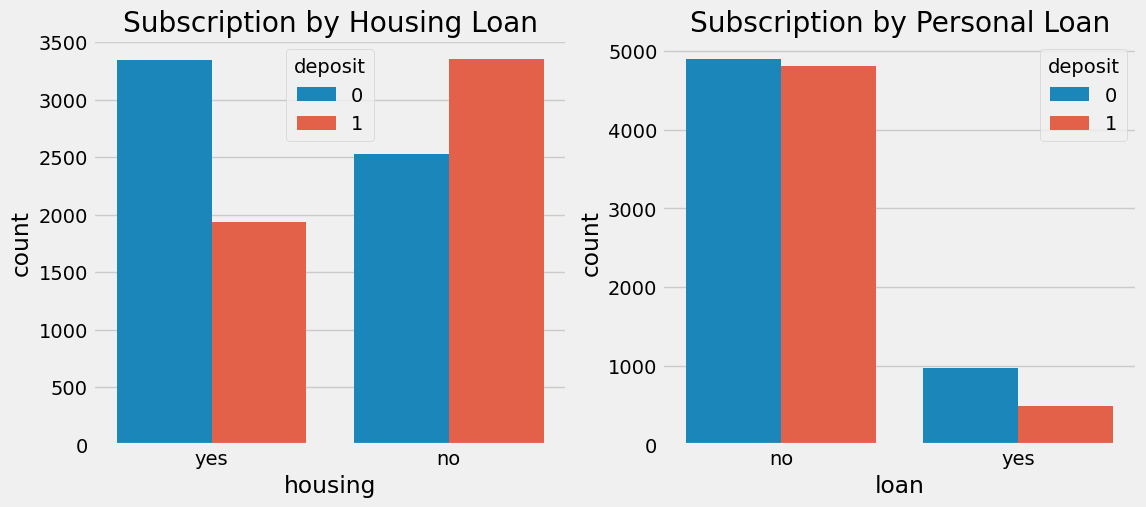

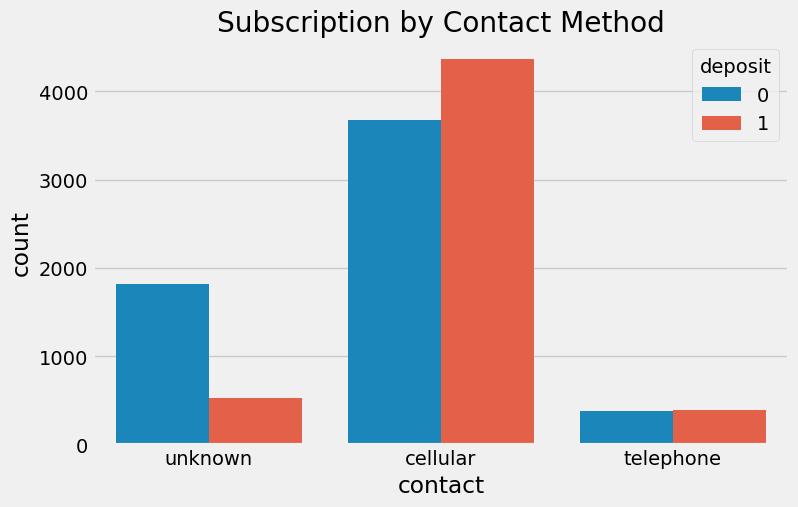

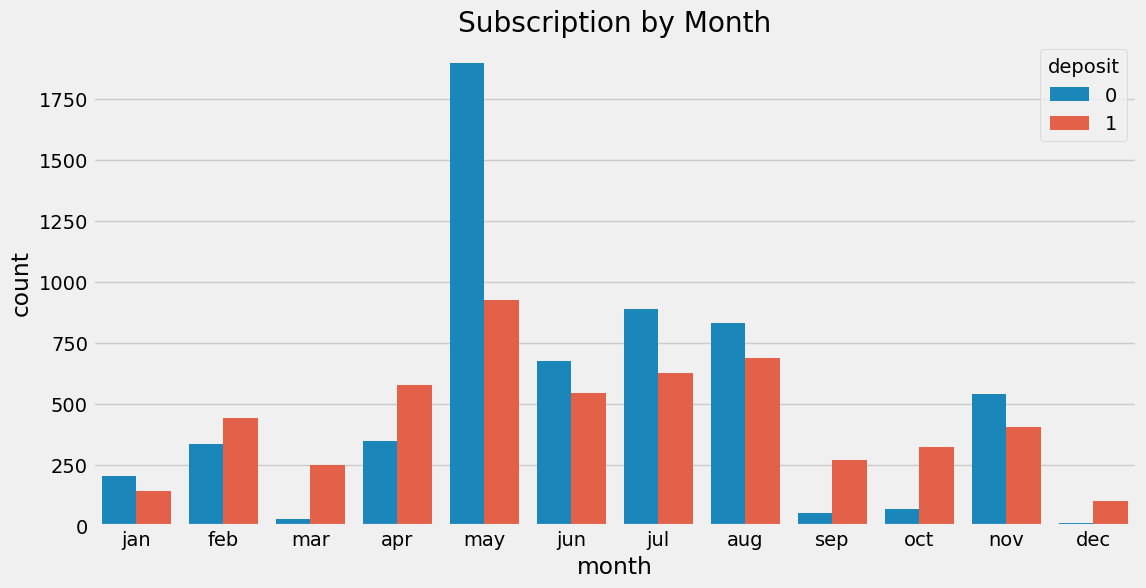

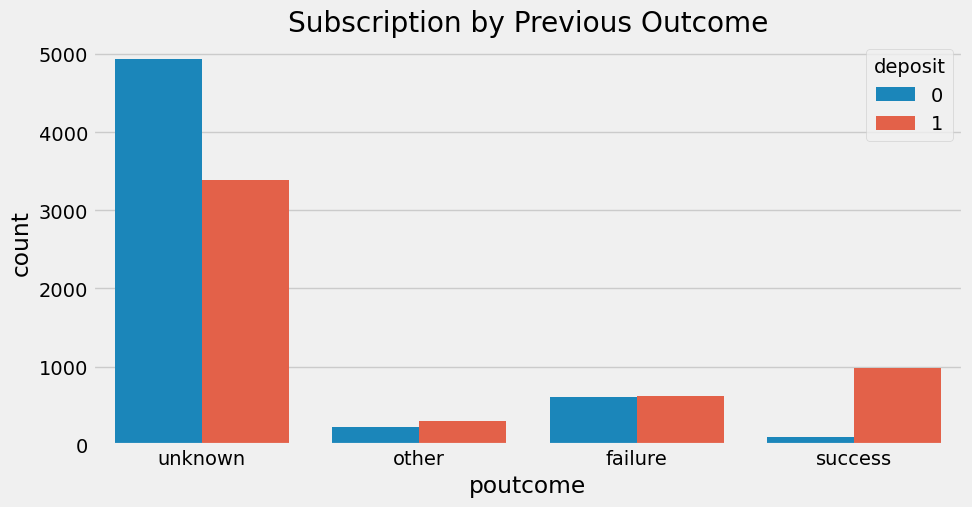

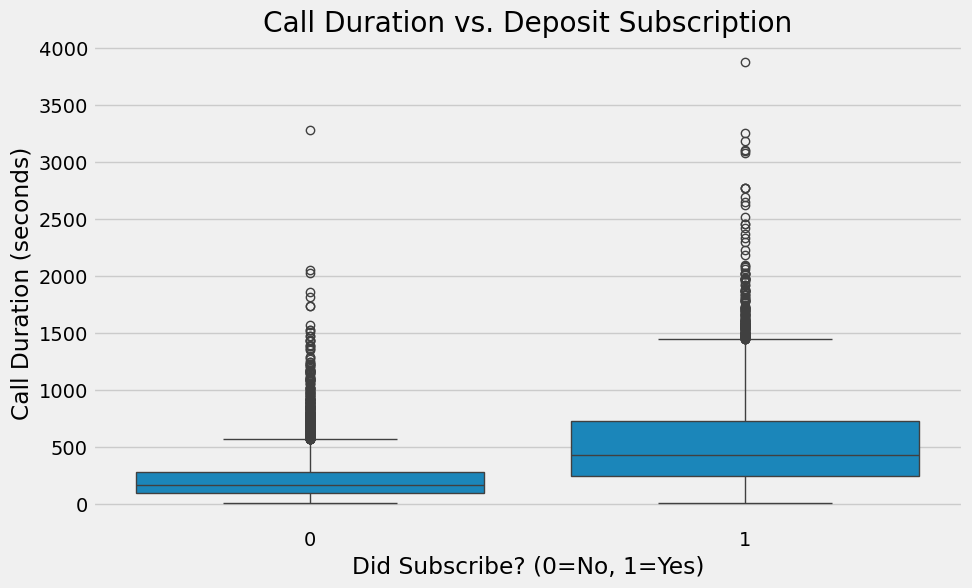


Call duration summary for successful subscriptions:
count    5289.000000
mean      537.294574
std       392.525262
min         8.000000
25%       244.000000
50%       426.000000
75%       725.000000
max      3881.000000
Name: duration, dtype: float64

Call duration summary for unsuccessful subscriptions:
count    5873.000000
mean      223.130257
std       208.577530
min         2.000000
25%        94.000000
50%       163.000000
75%       282.000000
max      3284.000000
Name: duration, dtype: float64


In [13]:
# -----------------------------------
# 1. 客户画像分析 (Who are our best customers?)
# -----------------------------------

# 分析职业(job)与购买意愿的关系
plt.figure(figsize=(12, 6))
sns.countplot(x='job', data=df, order = df['job'].value_counts().index, hue='deposit')
plt.title('Subscription by Job Type')
plt.xticks(rotation=45)
plt.show()

# 分析婚姻状况(marital)
plt.figure(figsize=(8, 5))
sns.countplot(x='marital', data=df, hue='deposit')
plt.title('Subscription by Marital Status')
plt.show()

# 分析教育程度(education)
plt.figure(figsize=(10, 5))
sns.countplot(x='education', data=df, order = df['education'].value_counts().index, hue='deposit')
plt.title('Subscription by Education Level')
plt.show()

# 分析是否有房贷/个人贷 (housing/loan)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.countplot(x='housing', data=df, hue='deposit', ax=ax1)
ax1.set_title('Subscription by Housing Loan')
sns.countplot(x='loan', data=df, hue='deposit', ax=ax2)
ax2.set_title('Subscription by Personal Loan')
plt.show()


# -----------------------------------
# 2. 营销策略分析 (How should we contact them?)
# -----------------------------------

# 分析联系方式(contact)
plt.figure(figsize=(8, 5))
sns.countplot(x='contact', data=df, hue='deposit')
plt.title('Subscription by Contact Method')
plt.show()

# 分析最后一次联系的月份(month)
plt.figure(figsize=(12, 6))
sns.countplot(x='month', data=df, order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], hue='deposit')
plt.title('Subscription by Month')
plt.show()

# -----------------------------------
# 3. 历史行为分析 (Does past behavior matter?)
# -----------------------------------

# 分析上一次营销活动的结果(poutcome)
plt.figure(figsize=(10, 5))
sns.countplot(x='poutcome', data=df, hue='deposit')
plt.title('Subscription by Previous Outcome')
plt.show()

# -----------------------------------
# 4. (重要)分析通话时长 - 仅为业务洞察，不用于建模
# -----------------------------------
# 我们用箱线图(Boxplot)来看不同通话时长下的购买情况
plt.figure(figsize=(10, 6))
sns.boxplot(x='deposit', y='duration', data=df)
plt.title('Call Duration vs. Deposit Subscription')
plt.xlabel('Did Subscribe? (0=No, 1=Yes)')
plt.ylabel('Call Duration (seconds)')
plt.show()

print("\nCall duration summary for successful subscriptions:")
print(df[df['deposit'] == 1]['duration'].describe())
print("\nCall duration summary for unsuccessful subscriptions:")
print(df[df['deposit'] == 0]['duration'].describe())

# 4. 特征工程与数据预处理

在对数据进行了深入的探索性分析之后，我们进入特征工程阶段。此阶段的目标是将原始数据转换为更适合机器学习模型的格式，并根据我们的业务洞察创造出新的特征。

**主要步骤包括:**
1.  **处理异常值与特殊值**: 对`pdays`中的-1等特殊值进行处理。
2.  **丢弃“数据泄露”特征**: 明确移除`duration`列，避免模型在训练时“作弊”。
3.  **类别特征编码**: 对所有的文本类别特征，使用独热编码(One-Hot Encoding)将其转换为数值格式。
4.  **划分数据集**: 将处理好的数据划分为训练集和测试集，为模型训练做准备。

In [14]:
# -----------------------------------
# 1. 拷贝数据，避免在原始DataFrame上直接修改
# -----------------------------------
from sklearn.model_selection import train_test_split


df_processed = df.copy()


# -----------------------------------
# 2. 特征处理与工程
# -----------------------------------

# 处理 'pdays' 特征: -1 表示从未联系过，这是一个很强的分类信息
# 我们可以创建一个新特征来标记这种情况
df_processed['pdays_never_contacted'] = (df_processed['pdays'] == -1).astype(int)

# 将 'pdays' 中的 -1 替换为 NaN，便于后续可能的数值分析，或让模型自己处理
df_processed['pdays'].replace({-1: np.nan}, inplace=True)


# 丢弃 'duration' 特征以避免数据泄露
# 同时，'day'和'month'的信息已经足够，我们也可以考虑丢弃它们，或者将它们组合成更有意义的特征
# 这里我们为了简化，先丢弃它们
df_processed = df_processed.drop(['duration', 'month', 'day'], axis=1)
print("Dropped 'duration', 'month', and 'day' columns.")


# -----------------------------------
# 3. 类别特征独热编码
# -----------------------------------
# 找出所有 object 类型的列 (类别特征)
categorical_features = df_processed.select_dtypes(include=['object']).columns
print("\nCategorical features to be one-hot encoded:", list(categorical_features))

# 使用 pd.get_dummies 进行独热编码
df_encoded = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True)
# drop_first=True 可以避免多重共线性问题，即在转换后的列中丢弃第一个类别

print("Shape after one-hot encoding:", df_encoded.shape)


# -----------------------------------
# 4. 划分训练集和测试集
# -----------------------------------
# X 是特征, y 是目标
X = df_encoded.drop('deposit', axis=1)
y = df_encoded['deposit']

# 划分数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Dropped 'duration', 'month', and 'day' columns.

Categorical features to be one-hot encoded: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
Shape after one-hot encoding: (11162, 31)

Training set shape: (7813, 30)
Testing set shape: (3349, 30)


# 5. 模型训练与评估

经过一系列的数据探索与预处理，我们现在拥有了可用于建模的高质量数据集。本节我们将搭建、训练并评估两个经典的分类模型，以预测客户的购买意愿。

*   **模型一：逻辑回归 (Logistic Regression)**: 作为一个可解释性强、稳定可靠的基线模型，它能为我们提供一个性能的参照标准。
*   **模型二：LightGBM**: 作为一个高性能的梯度提升树模型，我们期待它能捕捉到更复杂的特征关系，取得更高的预测精度。

**评估指标:**
*   **Accuracy (准确率)**: 由于本数据集样本相对均衡，我们可以使用准确率作为主要参考。
*   **AUC (ROC曲线下面积)**: 衡量模型整体的排序和判别能力。
*   **Classification Report**: 提供详细的Precision, Recall, F1-score，帮助我们深入理解模型的行为。

**本节目标:**
1.  分别训练逻辑回归和LightGBM模型。
2.  在测试集上评估并对比两个模型的性能。
3.  通过LightGBM的特征重要性，找出影响客户购买决策的最关键因素。

===== Training Logistic Regression Model =====
NaN values imputed for Logistic Regression.

Logistic Regression Performance:
Accuracy: 0.6739
AUC Score: 0.7376

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      1762
           1       0.66      0.64      0.65      1587

    accuracy                           0.67      3349
   macro avg       0.67      0.67      0.67      3349
weighted avg       0.67      0.67      0.67      3349



===== Training LightGBM Model =====
[LightGBM] [Info] Number of positive: 3702, number of negative: 4111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 7813, number of used features: 30
[LightGBM] [Info] [binary:Boost

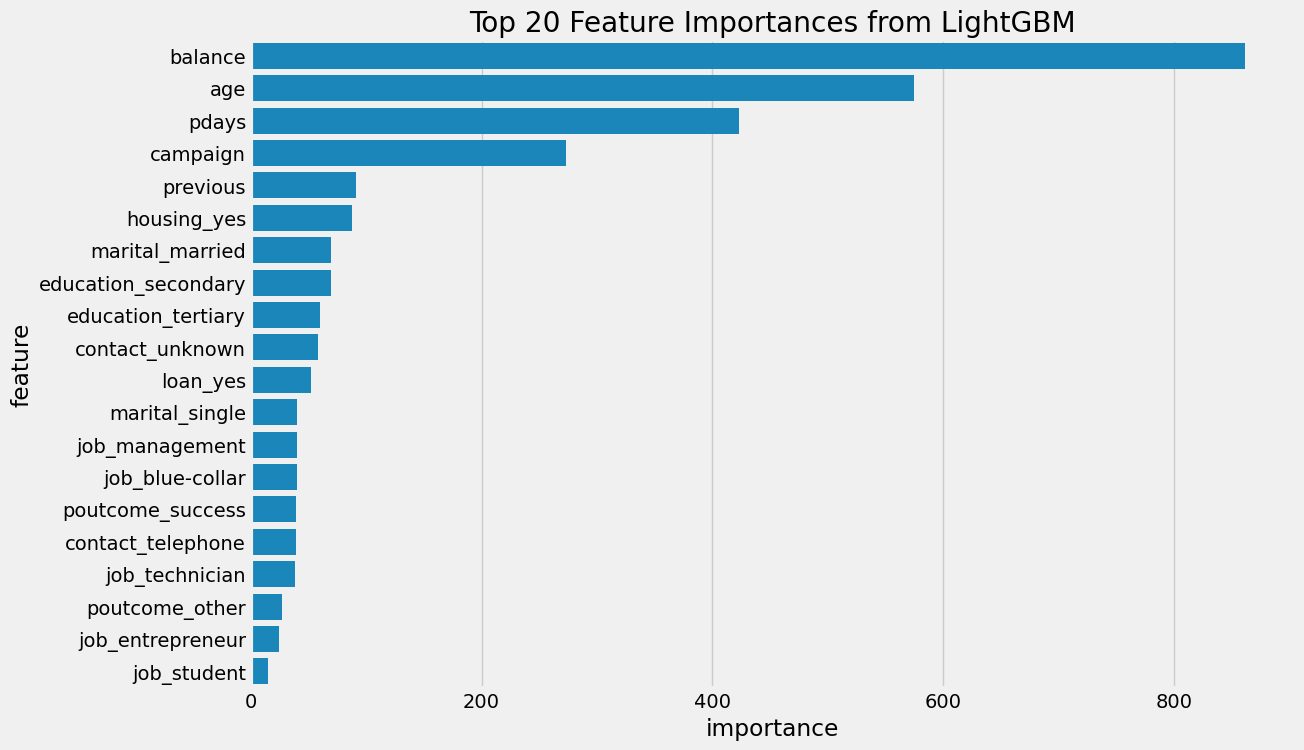

In [16]:
# -----------------------------------
# 1. 逻辑回归模型
# -----------------------------------
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

print("===== Training Logistic Regression Model =====")

# 创建一个填充器，使用中位数策略
imputer = SimpleImputer(strategy='median')

# 先用训练集的数据来'学习'中位数是多少
imputer.fit(X_train)

# 然后分别对训练集和测试集进行'转换'（即填充）
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)
print("NaN values imputed for Logistic Regression.")
# ------------------------------------

# 初始化模型
lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
# 使用填充过的数据进行训练
lr.fit(X_train_imputed, y_train)

# 在测试集上预测
# 同样，也要用填充过的数据进行预测
y_pred_lr = lr.predict(X_test_imputed)
y_pred_proba_lr = lr.predict_proba(X_test_imputed)[:, 1]
# 评估模型
print("\nLogistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))


# -----------------------------------
# 2. LightGBM 模型
# -----------------------------------
import lightgbm as lgb

print("\n\n===== Training LightGBM Model =====")
# 初始化模型
lgbm = lgb.LGBMClassifier(objective='binary', random_state=42)
lgbm.fit(X_train, y_train)

# 在测试集上预测
y_pred_lgbm = lgbm.predict(X_test)
y_pred_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]

# 评估模型
print("\nLightGBM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgbm):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba_lgbm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgbm))


# -----------------------------------
# 3. 特征重要性分析
# -----------------------------------
# 从训练好的LightGBM模型中获取特征重要性
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': lgbm.feature_importances_})
# 排序并选出Top 20
top_20_features = feature_importances.sort_values(by='importance', ascending=False).head(20)

# 可视化
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=top_20_features)
plt.title('Top 20 Feature Importances from LightGBM')
plt.show()

# 6. 结论与商业洞察

本项目通过对银行客户数据的深度分析与建模，成功构建了一个能够精准预测营销响应的机器学习模型。通过对比逻辑回归与LightGBM两种模型，我们不仅得出了高性能的预测结果，更重要的是，从模型中提炼出了具有高度商业价值的洞察。

## 模型性能对比与选择

| 模型 | Accuracy | AUC Score | 关键优势 |
| :--- | :--- | :--- | :--- |
| **逻辑回归** | 0.6739 | 0.7376 | 速度快，可解释性强 |
| **LightGBM** | **0.6975** | **0.7464** | **性能更优，能捕捉复杂关系** |

**结论**: **LightGBM** 在Accuracy和AUC两个核心指标上均优于逻辑回归，展现了其在处理复杂、非线性数据上的优势。因此，在追求最高预测精度的业务场景下，LightGBM是更优的选择。

## 核心商业洞察：高潜力客户画像

通过分析LightGBM输出的**Top 20特征重要性**，我们为银行营销团队描绘出了清晰的“高潜力客户”画像：


1.  **财务健康状况是基石 (`balance`)**: 客户的**账户余额**是**最重要**的预测特征。这表明，拥有良好经济基础的客户，是定期存款产品的核心目标客群。
2.  **生命周期与稳定性 (`age`, `pdays`, `campaign`, `previous`)**:
    *   **年龄(`age`)** 极为重要，说明不同年龄段客户的储蓄意愿和理财需求差异巨大。
    *   **历史接触记录**（`pdays`, `campaign`, `previous`）紧随其后。这揭示了客户的“营销成熟度”——如何把握接触频率、避免过度打扰，是提升转化率的关键。
3.  **资产与债务状况 (`housing_yes`)**: 是否有房贷是重要区分点。通常无房贷压力的客户，更有可能进行储蓄投资。
4.  **身份与背景 (`marital_married`, `education_...`, `job_...`)**: 客户的婚姻状况、教育背景和职业类型，共同构成了对其生活状态和消费习惯的判断，是客户分层的重要依据。
5.  **历史营销成果 (`poutcome_success`)**: 虽然本次排名不那么靠前，但在EDA中我们已发现，**上一次营销成功的客户是转化率极高的金矿**，应作为最优先维护的客群。

## 策略建议与项目价值

基于以上洞察，可为银行提供以下数据驱动的策略建议：
*   **客户分层营销**: 针对**高余额、无房贷、中年、已婚**等特征的客群，设计更具吸引力的存款产品并优先营销。
*   **智能接触策略**: 基于`pdays`, `campaign`等历史数据，为每个客户建立“最佳接触时机模型”，实现个性化营销，避免资源浪费和客户反感。
*   **交叉销售机会**: 对于已购买产品的`poutcome_success`客户，可以进一步推荐其他理财产品，深挖客户价值。

**总结**: 本项目不仅构建了一个预测模型，更提供了一套完整的“**数据洞察 -> 客户画像 -> 策略建议**”的商业分析框架，充分展示了将数据科学应用于驱动业务增长的价值。